<a href="https://colab.research.google.com/github/Chanaka3534/FYP_LSTM/blob/main/FYP(LSTM_MODEL).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Load dataset
df = pd.read_csv('FYP_DATA.csv')

In [3]:
# Convert numeric columns
df['Resovior water level(m)'] = pd.to_numeric(df['Resovior water level(m)'], errors='coerce')
df['Resovior discharge rate'] = pd.to_numeric(df['Resovior discharge rate'], errors='coerce')
df['Water level(Kaliodai)'] = pd.to_numeric(df['Water level(Kaliodai)'], errors='coerce')

In [4]:
# Drop rows with NaN
df = df.dropna()

# Select features and target
features = df[['Catchment Rainfall', 'Downstream rainfall', 'Resovior water level(m)', 'Resovior discharge rate']]
target = df['Water level(Kaliodai)'].values.reshape(-1, 1)

In [5]:
# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(features)
y_scaled = scaler_y.fit_transform(target)

In [6]:
# Sequence generator (30 days)
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 30
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

In [7]:
# Train-test split
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]

In [15]:
# Build LSTM
model = Sequential([
    LSTM(64, input_shape=(TIME_STEPS, 4)),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0857 - val_loss: 0.0427
Epoch 2/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0297 - val_loss: 0.0437
Epoch 3/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0281 - val_loss: 0.0426
Epoch 4/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0292 - val_loss: 0.0405
Epoch 5/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0262 - val_loss: 0.0387
Epoch 6/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0250 - val_loss: 0.0516
Epoch 7/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0262 - val_loss: 0.0383
Epoch 8/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0255 - val_loss: 0.0376
Epoch 9/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0242 - val_loss: 0.0433
Epoch 10/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0250 - val_loss: 0.0381
Epoch 11/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0231 - val_loss: 0.0543
Epoch 12/100
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0

In [16]:
# Predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_actual = scaler_y.inverse_transform(y_test)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


In [17]:
# Categorization function
def categorize_level(value):
    if value < 2500:
        return "NO"
    elif value < 2800:
        return "LOW"
    elif value < 2900:
        return "MEDIUM"
    else:
        return "HIGH"

# Apply categorization
predicted_classes = [categorize_level(y) for y in y_pred.flatten()]
actual_classes = df['Flood risk'].values[-len(predicted_classes):]

In [18]:
# Evaluation
print("Classification Report:")
print(classification_report(actual_classes, predicted_classes))

print("Confusion Matrix:")
print(confusion_matrix(actual_classes, predicted_classes))

Classification Report:
              precision    recall  f1-score   support

        HIGH       0.00      0.00      0.00         4
         LOW       0.20      0.50      0.29         2
      MEDIUM       0.33      0.50      0.40         2
          NO       0.99      0.99      0.99       302

    accuracy                           0.97       310
   macro avg       0.38      0.50      0.42       310
weighted avg       0.97      0.97      0.97       310

Confusion Matrix:
[[  0   1   2   1]
 [  0   1   0   1]
 [  0   0   1   1]
 [  0   3   0 299]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


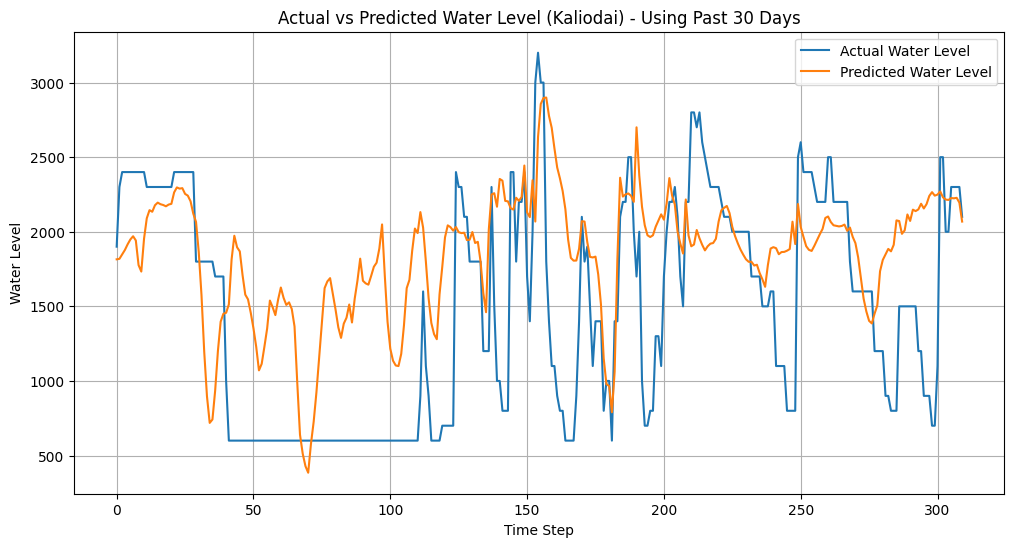

In [19]:
# Plot actual vs predicted water levels
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Water Level')
plt.plot(y_pred, label='Predicted Water Level')
plt.title('Actual vs Predicted Water Level (Kaliodai) - Using Past 30 Days')
plt.xlabel('Time Step')
plt.ylabel('Water Level')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Your 30-day manual input goes here
manual_data = [
    # Replace with your real data...
    [6.7,0, 103.2,1700],
    [9.1, 0, 103.2, 1700],
    [10, 10.5, 103.1, 1700],
    [9.5, 0, 103.1, 1500],
    [16.2, 0, 103, 1700],
    [13.6, 28.4, 102.9, 1600],
    [6.3, 16, 102.8, 1600],
    [13.6, 3.2, 102.8, 400],
    [1.7, 0, 102.9, 500],
    [1.3, 29.3, 103.1, 500],
    [14.1, 0, 103.3, 300],
    [0.5, 0, 103.5, 1100],
    [2.5, 0, 103.5, 750],
    [3.7, 0, 103.4, 750],
    [13.5, 0, 103.4, 1050],
    [4.7, 0, 103.8, 1150],
    [4.9, 0, 103.9, 1600],
    [0.4, 0, 103.9, 1600],
    [2.1, 2, 103.9, 1800],
    [2.6, 0, 103.9, 1500],
    [1.1, 0, 103.9, 1600],
    [7, 5.3, 103.9, 1600],
    [8.6, 0, 104.1, 1250],
    [2.7, 0, 104.2, 1150],
    [5.4, 0, 104.4, 1150],
    [13.3, 0, 104.4, 1250],
    [1.7, 0, 104.5, 1250],
    [15.3, 0, 104.6, 1250],
    [4, 0, 104.8, 900],
    [15.1, 22, 105.1, 0],
]

# Convert to DataFrame
manual_df = pd.DataFrame(manual_data, columns=['Catchment Rainfall', 'Downstream rainfall', 'Resovior water level(m)', 'Resovior discharge rate'])

# Scale using the same scaler used during training
manual_scaled = scaler_X.transform(manual_df)

# Reshape for LSTM: (1, 30, 4)
X_input = np.array([manual_scaled])

# Predict
predicted_scaled = model.predict(X_input)
predicted_water_level = scaler_y.inverse_transform(predicted_scaled)[0][0]


predicted_class = categorize_level(predicted_water_level)

# Output
print(f"📈 Predicted water level for tomorrow: {predicted_water_level:.2f}")
print(f"🚦 Predicted flood risk category: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
📈 Predicted water level for tomorrow: 2071.39
🚦 Predicted flood risk category: NO
